# How to use `knockpy`

## 概要

このノートブックでは[公式チュートリアル](https://amspector100.github.io/knockpy/usage.html)を参考に、「機械学習の炊いたん7。」で使用した`Knockoff`のコードをまとめた。

### Knockoff とは？

Knockoff の目的は、所与の目的変数$y$と説明変数$X$の組みから、**False Discovery Rate（偽発見率・偽陽性率）をコントロールしながら**、$y$に依存する少数の特徴$X_i$を選択することにある。

例えば、LassoなどのスパースモデリングにKnockoffを適用してみる。この場合、ある変数が陽性とは非ゼロ$\beta_i\neq0$であることを意味し、また陰性とはゼロ$\beta_i=0$であることを意味する。
$$
\min_{\beta\in\mathbb{R}^P}\frac{1}{2N}\|y-X\beta\|_2^2+\lambda\|\beta\|
$$

通常は、正則化係数$\lambda$は適当な値を使用するか、モデルの良さを評価する指標（RMSE）などに基づいてモデル選択などで決定される。その結果、真の解$\beta^{0}$のスパースな推定解$\hat{\beta}$を得る。

Knockoffでは所望のFDR値以下の正則化係数を見つけることができる。この$\lambda$に応じたスパースな推定解$\hat{\beta}$では所望のFDR以下で偽陽性が制御できていることが期待される。実質的にFDRに基づくモデル選択にイメージが近い。

## パッケージの読み込み

In [1]:
import numpy as np
import sklearn as sk
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import tqdm

import knockpy

import warnings
# 警告の非表示
warnings.simplefilter('ignore')

## 基本的な使い方

### データ生成

$y=X\beta+\epsilon$

$X\sim\mathcal{N}(0,\Sigma)$

$\Sigma_{ij}=\rho^{|i-j|}$

$$
\Sigma=\left[
\begin{array}{cccccc}
1 & 0.5 & 0.25 & 0.125 & \cdots & 0.5^{|P-1|}\\
0.5 & 1 & 0.5 & 0.25 & \cdots & 0.5^{|P-2|}\\
0.25 & 0.5 & 1 & 0.5 & \cdots & 0.5^{|P-3|}\\
0.125 & 0.25 & 0.5 & 1 & \cdots & 0.5^{|P-4|}\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0.5^{|P-1|} & 0.5^{|P-2|} & 0.5^{|P-3|} & 0.5^{|P-4|} & \cdots & 1
\end{array}
\right]\in\mathbb{R}^{P\times P}
$$

In [2]:
# 設定
np.random.seed(1)  # 乱数の種

n = 500  # サンプル数
p = 500  # 特徴数

# 特徴量の生成
Sigma = knockpy.dgp.AR1(p=p, rho=0.5) # 定常AR1過程の共分散行列（rho=0.5）
X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=(n,))

# パラメータの生成
# 各要素は{-1,0,1}からランダムに決定(sparsity=非ゼロパラメータの割合)
beta = knockpy.dgp.create_sparse_coefficients(p=p, sparsity=0.1)

# 目的変数の生成（ノイズが印加）
y = np.dot(X, beta) + np.random.randn(n)

### Knockoffによる特徴選択（共分散行列が既知の場合）

In [3]:
# フィルタの作成
kfilter = knockpy.KnockoffFilter(
    ksampler='gaussian',  # サンプラーの設定
    fstat='lasso',  #  統計量の設定
)

# Knockoffでの特徴選択 ＆ 選択された特徴量をバイナリでフラグ付け
rejections = kfilter.forward(
    X=X,  # 特徴量
    y=y,  # 目的変数
    Sigma=Sigma,  # 共分散行列
    fdr=0.1 # FDRの制御値
)

# 検出力とFDPを計算
# betaは真のパラメータ，　rejectionsはKnockoffで選択されたパラメータ
power = np.dot(rejections, beta != 0) / (beta != 0).sum()  # 検出力
fdp = np.dot(rejections, beta == 0) / rejections.sum()  # FDP
print(f"検出力:\t{np.around(100*power,2)}%\nFDP:\t{np.around(100*fdp,2)}%")

検出力:	100.0%
FDP:	10.71%


In [4]:
# FDRの制御値ごとに複数回実行する（共分散行列既知）
FDRs = np.arange(0,1,0.01)  # FDRの探索グリッド
num_trials = 10  # 各FDRでの試行回数

def fdp_trials_Sigma(FDR):
    results_fdp = np.zeros(num_trials)
    for t in range(num_trials):
        rejections = kfilter.forward(
            X=X,  # 特徴量
            y=y,  # 目的変数
            Sigma=Sigma,  # 共分散行列
            fdr=FDR # FDRの制御値
        )
        if rejections.sum():
            results_fdp[t] = np.dot(rejections, beta == 0) / rejections.sum()  # FDP    
    return FDR, results_fdp

results = joblib.Parallel(n_jobs=-1, verbose=0)([joblib.delayed(fdp_trials_Sigma)(FDR) for FDR in FDRs])

FDRs_true = np.array([result[0] for result in results])
FDRs_hat = np.array([result[1] for result in results])

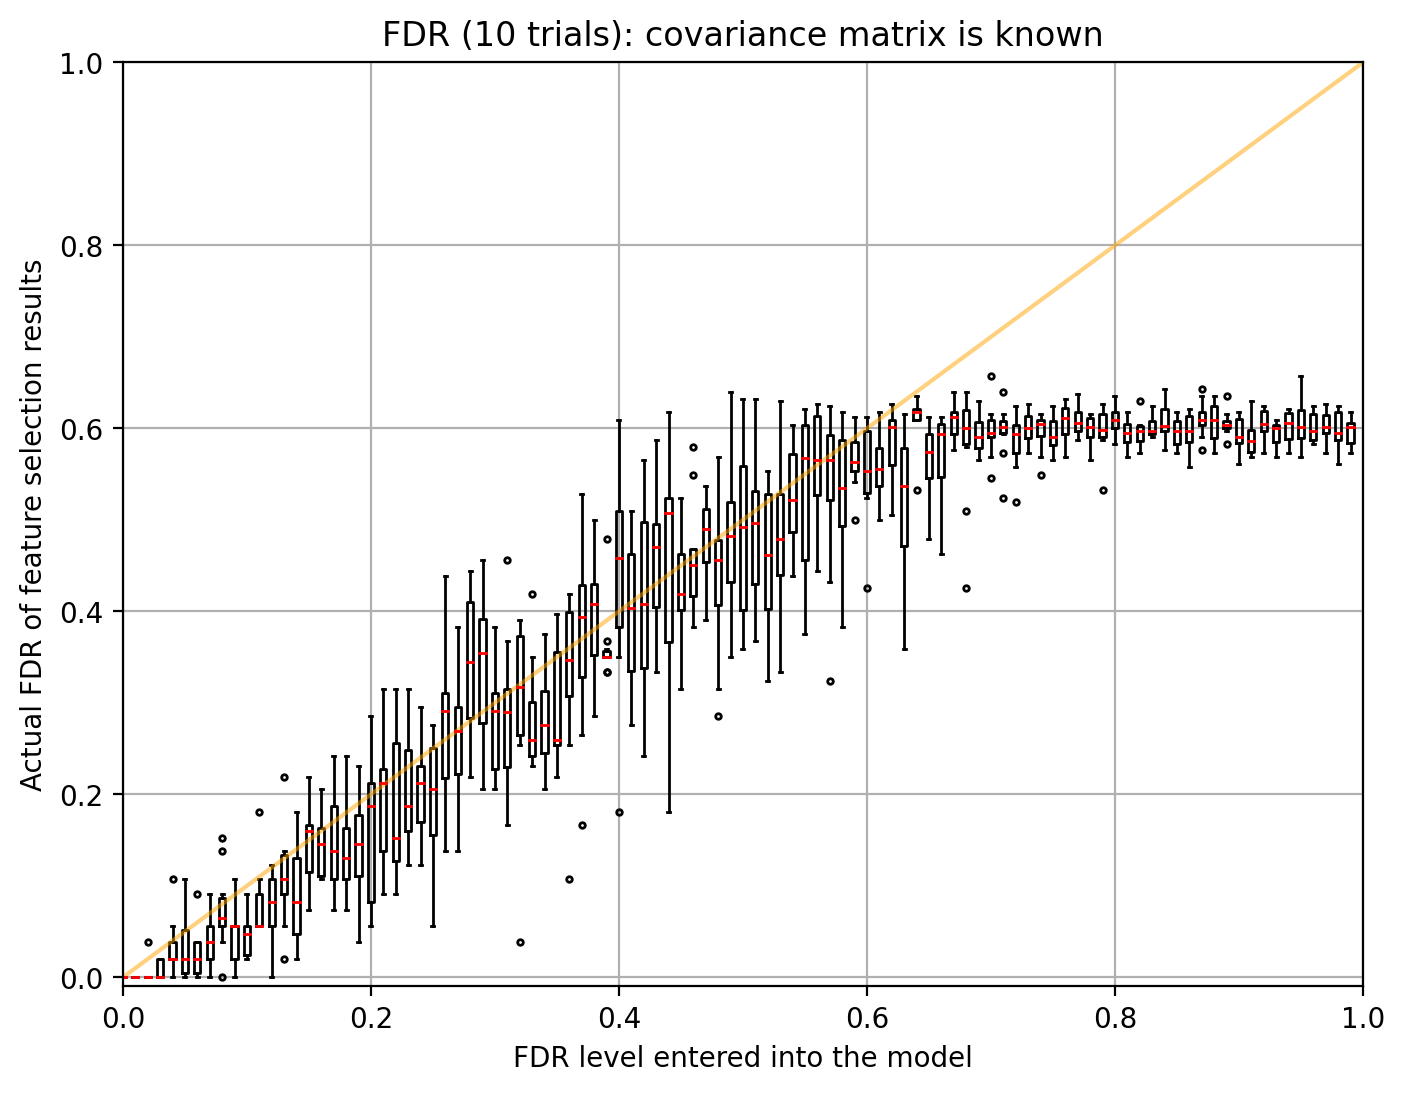

In [5]:
# 結果の可視化
plt.figure(figsize=[8,6], dpi=200)

# 箱ひげ図（中央値を赤く着色）
plt.boxplot(FDRs_hat.T, positions=FDRs_true*100, medianprops=dict(color='r', lw=1), flierprops=dict(ms=2))
# 橙線は理想値（この線以下であるとよい）
plt.plot([0,100],[0,1], color='orange', alpha=0.5)

plt.xlim(0,1)
plt.xlabel('FDR level entered into the model')
plt.xticks(np.linspace(0,1,6)*100, np.round(np.linspace(0,1,6),1))
plt.ylim(-0.01,1)
plt.ylabel('Actual FDR of feature selection results')

plt.title(f'FDR ({num_trials} trials): covariance matrix is known')
plt.grid()
plt.show()

### Knockoffによる特徴選択（共分散行列が未知の場合）

In [6]:
# フィルタの作成
kfilter = knockpy.KnockoffFilter(
    ksampler='gaussian', 
    fstat='lasso'
)

# Knockoffでの特徴選択 ＆ 選択された特徴量をバイナリでフラグ付け
rejections = kfilter.forward(
    X=X,  # 特徴量
    y=y,  # 目的変数
    shrinkage="ledoitwolf",  # 共分散行列の推定手法
    fdr=0.1  # FDRの制御値
)

# 検出力とFDPを計算
# betaは真のパラメータ，　rejectionsはKnockoffで選択されたパラメータ
power = np.dot(rejections, beta != 0) / (beta != 0).sum()
fdp = np.dot(rejections, beta == 0) / rejections.sum()
print(f"検出力:\t{np.around(100*power,2)}%\nFDP:\t{np.around(100*fdp,2)}%")

検出力:	100.0%
FDP:	3.85%


In [7]:
# FDRの制御値ごとに複数回実行する（共分散行列既知）
FDRs = np.arange(0,1,0.01)  # FDRの探索グリッド
num_trials = 10  # 各FDRでの試行回数

def fdp_trials_shrinkage(FDR):
    results_fdp = np.zeros(num_trials)
    for t in range(num_trials):
        rejections = kfilter.forward(
            X=X,  # 特徴量
            y=y,  # 目的変数
            shrinkage="ledoitwolf",  # 共分散行列の推定手法
            fdr=FDR # FDRの制御値
        )
        if rejections.sum():
            results_fdp[t] = np.dot(rejections, beta == 0) / rejections.sum()  # FDP
    return FDR, results_fdp

results = joblib.Parallel(n_jobs=-1, verbose=0)([joblib.delayed(fdp_trials_shrinkage)(FDR) for FDR in FDRs])

FDRs_true = np.array([result[0] for result in results])
FDRs_hat = np.array([result[1] for result in results])

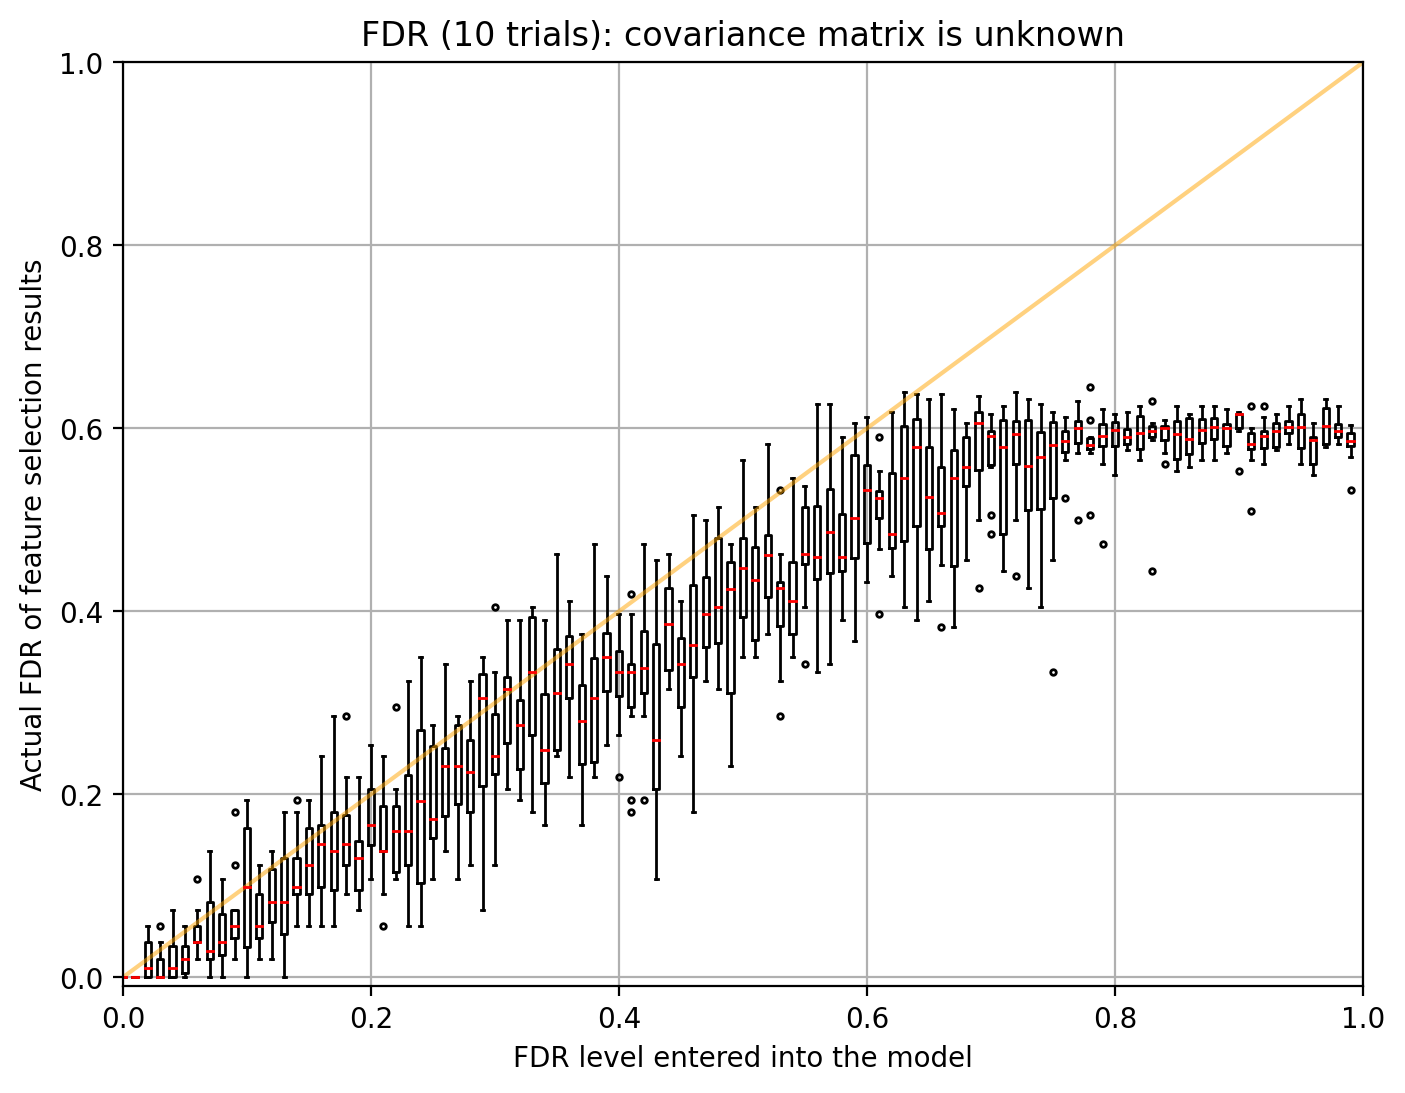

In [8]:
# 結果の可視化
plt.figure(figsize=[8,6], dpi=200)

# 箱ひげ図（中央値を赤く着色）
plt.boxplot(FDRs_hat.T, positions=FDRs_true*100, medianprops=dict(color='r', lw=1), flierprops=dict(ms=2))
# 橙線は理想値（この線以下であるとよい）
plt.plot([0,100],[0,1], color='orange', alpha=0.5)

plt.xlim(0,1)
plt.xlabel('FDR level entered into the model')
plt.xticks(np.linspace(0,1,6)*100, np.round(np.linspace(0,1,6),1))
plt.ylim(-0.01,1)
plt.ylabel('Actual FDR of feature selection results')

plt.title(f'FDR ({num_trials} trials): covariance matrix is unknown')
plt.grid()
plt.show()

## 特徴選択の原理

- Knockoff特徴量が得られたとする
- 正則化係数を統計量とするようなKnockoffの動きを見てみる

In [9]:
# 正則化係数のグリッド
lams = np.logspace(-2, 0.5, 5000)

# Knockoff特徴量
Xk = kfilter.Xk

# 各正則化係数におけるパラメータの推定解をlasso_pathを用いて計算
_, coefs_all, _ = sk.linear_model.lasso_path(np.c_[X,Xk], y, alphas=lams)

# 推定結果の整理
coefs = coefs_all[:p,::-1]  # 元の特徴量に対応した推定パス
coefsk = coefs_all[p:,::-1]  # Knockoff特徴量に対応した推定パス

# 初めて非ゼロとなる正則化係数のインデックス
index = [np.min(np.where(coefs[i]==0)[0]) for i in range(p)]  # 元の特徴量に対応したインデックス
indexk = [np.min(np.where(coefsk[i]==0)[0]) for i in range(p)]  # Knockoff特徴量に対応したインデックス

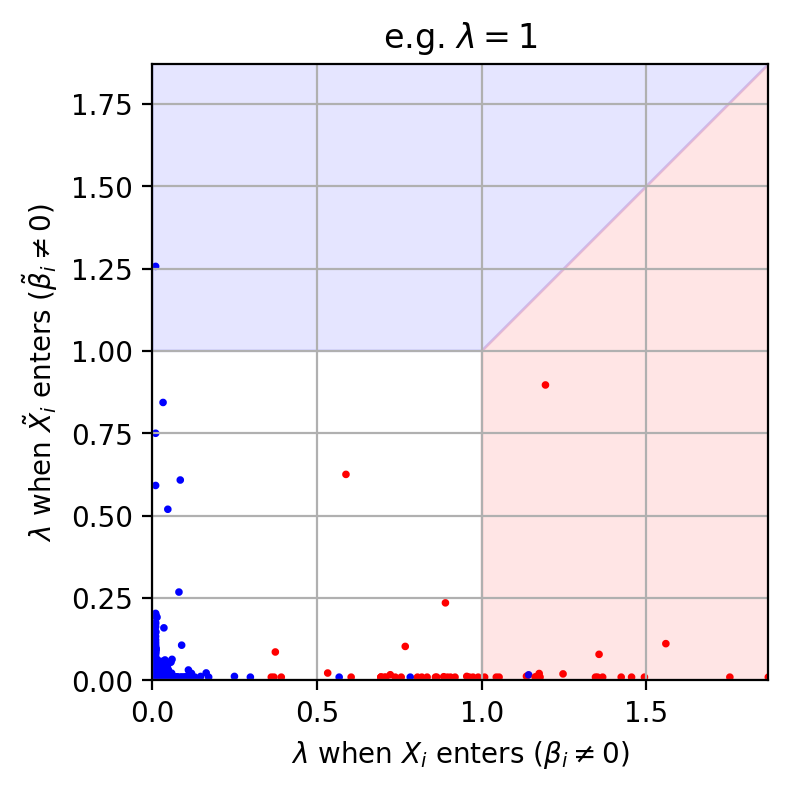

In [10]:
# 統計量（正則化係数）の可視化
# 横軸元の特徴量と縦軸Knockoff特徴量に対応した統計量の散布図

plt.figure(figsize=[4,4], dpi=200)
plt.axes().set_aspect('equal')

# 赤点は真のパラメータが非ゼロ，青点は真のパラメータがゼロ
plt.scatter(lams[index], lams[indexk], c=beta.astype(bool), cmap='bwr', s=3)

# 正則化係数が1の場合にカウントされるエリア
# (青エリアの点の個数)／（赤エリアの点の個数）＝FDRの推定値
# 青エリアの点の個数が偽発見の個数（赤エリア内の青点の個数）を推定
# 今回の場合は偽発見が1点なので上手くいっている
threshold = 1
plt.fill_between(lams, lams, color='red', where=lams>threshold, alpha=0.1)
plt.fill_betweenx(lams, lams, color='blue', where=lams>threshold, alpha=0.1)

xlim_max = lams[np.max(np.r_[index, indexk])]
plt.xlim(0,xlim_max)
plt.xlabel(r'$\lambda$ when $X_i$ enters ($\beta_i\neq0$)')
plt.ylim(0,xlim_max)
plt.ylabel(r'$\lambda$ when $\tilde{X}_i$ enters ($\tilde{\beta}_i\neq0$)')

plt.title(fr'e.g. $\lambda=${threshold}')
plt.grid()
plt.show()

In [11]:
# 各正則化係数におけるKnockoffで推定されたFDRと真のFDR
coefs_bool = coefs.astype(bool)  # 推定されたパラメータのゼロ非ゼロバイナリ
beta_bool = beta.astype(bool)  # 真のパラメータのゼロ非ゼロバイナリ

# Knockoffに基づくFDRの推定
W = np.array([lams[max(index[i],indexk[i])]*np.sign(index[i]-indexk[i]) for i in range(p)])
FDP_hat = np.nan_to_num([sum(W<-lam)/sum(W>lam) for lam in lams])

# 真のFDRの計算（混合行列を使用）
confusion_matrices = np.array([sk.metrics.confusion_matrix(beta_bool, W>lam)[:,1] for lam in lams])
FDP_true = np.nan_to_num(confusion_matrices[:,0]/np.sum(confusion_matrices, axis=1))

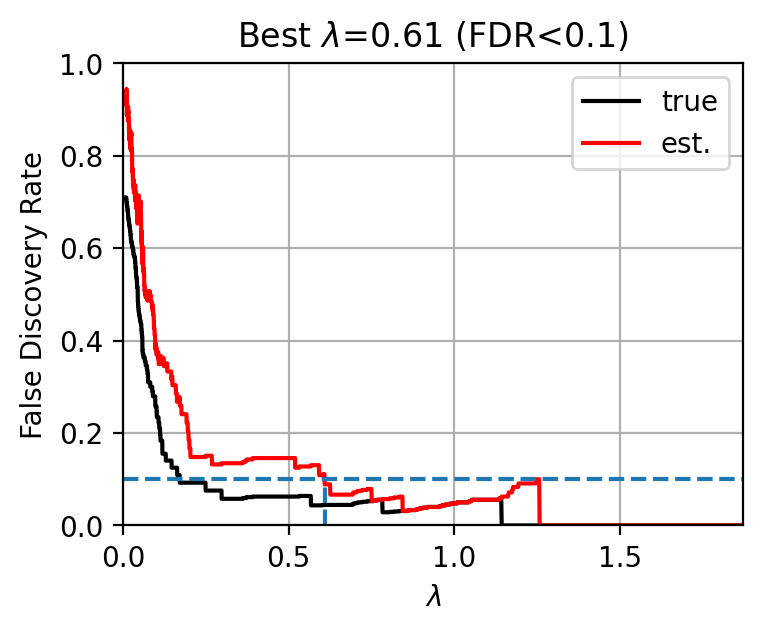

In [12]:
# 正則化係数ごとのKnockoffで推定されたFDRと真のFDR
# 横軸正則化係数，縦軸FDR
# 黒線が真のFDR，赤線が推定されたFDR
# 破線は正則化係数の推定イメージで，FDRの制御値が推定FDR（赤線）以下となる最小の正則化係数を選択
plt.figure(figsize=[4,3], dpi=200)

plt.plot(lams, FDP_true, color='black', label='true')
plt.plot(lams, FDP_hat, color='red', label='est.')

q = 0.1
plt.hlines(q, 0, xlim_max, linestyle='dashed')
plt.vlines(lams[FDP_hat<q][0], 0, q, linestyle='dashed')

plt.xlim(0,xlim_max)
plt.xlabel(r'$\lambda$')
plt.ylim(0,1)
plt.ylabel('False Discovery Rate')

plt.title(fr'Best $\lambda$={round(lams[FDP_hat<q][0],2)} (FDR<{q})')
plt.grid()
plt.legend()
plt.show()

## 発展的な使い方

### `knockpy.KnockoffFilter`（フィルタの設定）

`ksampler`（Knockoff特徴量のサンプリング手法）の引数
- `gaussian`: Gaussian Model-X knockoffs（デフォルト）
- `fx`: Fixed-X knockoffs.
- `metro`: Generic metropolized knockoff sampler
- `artk`: t-tailed Markov chain.
- `blockt`: Blocks of t-distributed
- `gibbs_grid`: Discrete gibbs grid

`fstat`（Knockoffで用いる統計量の計算方法）の引数（個別の計算方法のオプションは`fstat_kwargs`で指定）
- `lasso` or `lcd`: cross-validated lasso coefficients differences（デフォルト）
- `mlr`: the masked likelihood ratio (MLR) statistic
- `lsm`: signed maximum of the lasso path statistic
- `dlasso`: Cross-validated debiased lasso coefficients
- `ridge`: Cross validated ridge coefficients
- `ols`: Ordinary least squares coefficients
- `margcorr`: marginal correlations between features and response
- `deeppink`: The deepPINK statistic
- `mlrspline` or `spline`: The MLR statistic applied to regression spline basis functions
- `randomforest`: A random forest with swap importances

`knockoff_kwargs`（`method`でKnockoff特徴量を調整する共分散行列）の引数（詳細は下記）
- `maxent`: to minimize the mutual information (MI)
- `sdp`: to minimize the mean absolute covariance (MAC)
- `mvr`: to minimize MAC with increasing computational efficiency but reducing statistical power
- `ci`: to seek the conditional independence (CI)

In [13]:
# 【参考】特徴量とKnockoff特徴量の差となる共分散行列（線形の場合は1-内積に相当）

S_MAXENT = knockpy.smatrix.compute_smatrix(
    Sigma, 
    method='maxent'
)

S_SDP = knockpy.smatrix.compute_smatrix(
    Sigma, 
    method='sdp'
)

S_MVR = knockpy.smatrix.compute_smatrix(
    Sigma, 
    method='mvr'
)

S_CI = knockpy.smatrix.compute_smatrix(
    Sigma, 
    method='ci'
)

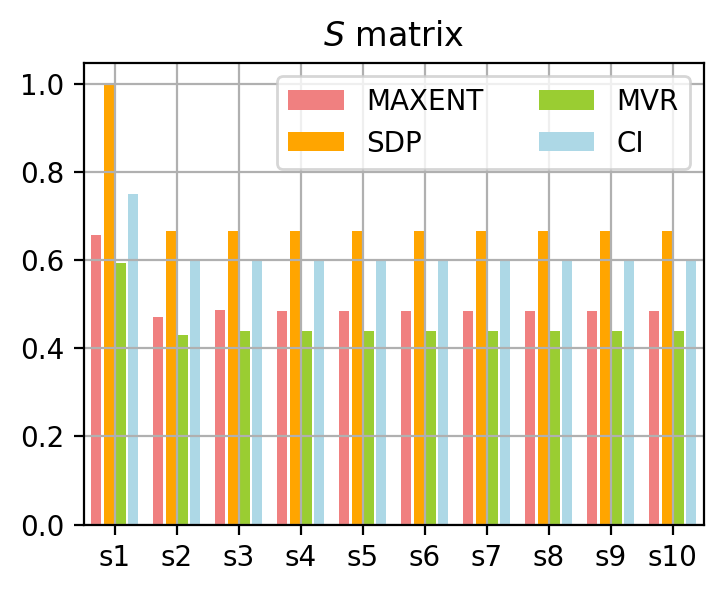

In [14]:
# 【参考】S行列の推定結果のうち最初の10個を可視化
plt.figure(figsize=[4,3], dpi=200)
plt.bar(5*np.arange(10)+1, np.diag(S_MAXENT)[:10], label='MAXENT', color='lightcoral')
plt.bar(5*np.arange(10)+2, np.diag(S_SDP)[:10], label='SDP', color='orange')
plt.bar(5*np.arange(10)+3, np.diag(S_MVR)[:10], label='MVR', color='yellowgreen')
plt.bar(5*np.arange(10)+4, np.diag(S_CI)[:10], label='CI', color='lightblue')
plt.xlim(0,5*10)
plt.xticks(5*np.arange(10)+2.5, [f's{i}' for i in np.arange(10)+1])
plt.grid()
plt.legend(ncol=2)
plt.title(r'$S$ matrix')
plt.show()

In [15]:
# maxentに基づいて共分散行列を調整したGaussian(knockoff)で統計量はMLRを使いたい
kfilter = knockpy.KnockoffFilter(
    ksampler='gaussian',
    fstat='mlr',
    knockoff_kwargs={'method':'maxent'}
)

### `knockpy.KnockoffFilter.forward`（Knockoffの実行）

主な引数
- `X`: 説明変数（特徴量）
- `y`: 目的変数
- `fdr`: FDRレベル
- `shrinkage`: 共分散行列の推定方法（`ledoitWolf`, `MLE`, `graphicallasso`）

事前情報がある場合（任意）
- `Xk`: Knockoff特徴量（Noneの場合は推定）
- `mu`: 特徴量の平均（Noneの場合は標本平均）
- `Sigma`: 特徴量の共分散行列（Noneの場合は標本共分散行列）

In [16]:
# 共分散行列の推定はGraphical lassoで実施し、FDR<0.1以下を目標とするKnockoff
rejections = kfilter.forward(
    X=X,
    y=y,
    fdr=0.1,
    shrinkage='graphicallasso'
)

In [17]:
# 検出力とFDPを計算
# betaは真のパラメータ，　rejectionsはKnockoffで選択されたパラメータ
power = np.dot(rejections, beta != 0) / (beta != 0).sum()
fdp = np.dot(rejections, beta == 0) / rejections.sum()
print(f"検出力:\t{np.around(100*power,2)}%\nFDP:\t{np.around(100*fdp,2)}%")

検出力:	100.0%
FDP:	5.66%
